In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import control as ct
import enel441_utilities as eu
import scipy as sp

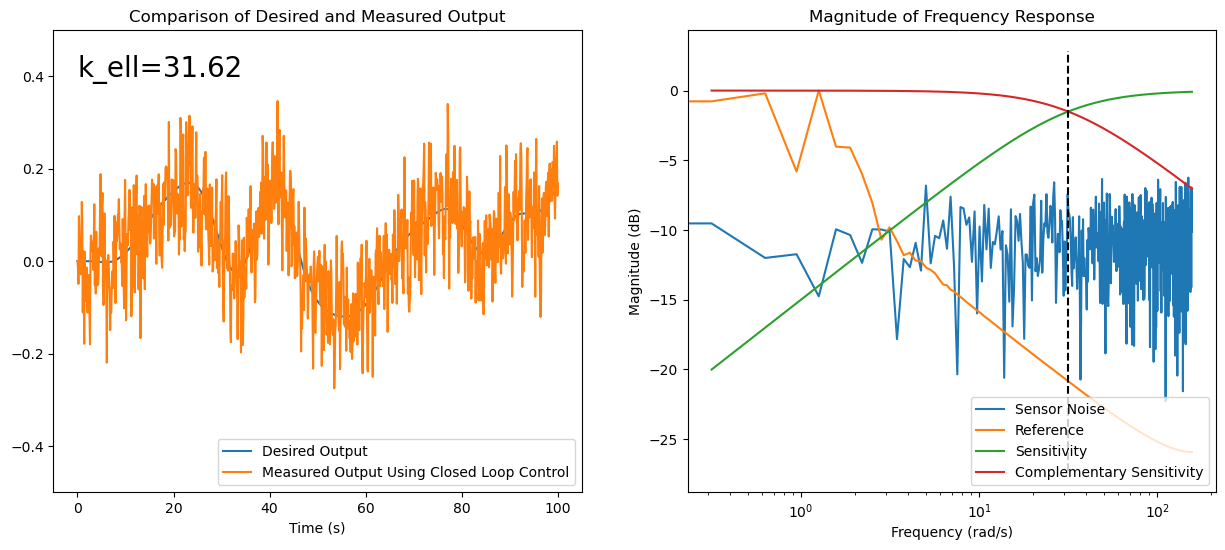

In [11]:

J1 = 2
J2 = 5
k = 10
b = 0.5


# transfer function numerator and denominator (from equations)
P_num = np.array([1])
P_den = np.array([J1*J2/k, (J1+J2)*b/k, (J1+J2+b**2/k), 2*b, 0])

N = 1000

rr = np.random.randn(N)
b, a = sp.signal.butter(5, 0.01, 'low')
r = sp.signal.lfilter(b, a, rr)

b, a = sp.signal.butter(5, 0.1, 'low')
d = 0.1*sp.signal.lfilter(b, a, np.random.randn(N))
#d += np.linspace(0,1,N)
  
n = 0.1*np.random.randn(N)

t = np.linspace(0,100,N)
w = sp.fft.fftfreq(N,1/100)*np.pi

NN = abs(sp.fft.fft(n))
DD = abs(sp.fft.fft(d))
RR = abs(sp.fft.fft(r))


k_ell_vec = np.logspace(-1,1.5,500)


# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Loop Shaping', artist='Matplotlib',
                comment='visualize effect of changing kl')
writer = FFMpegWriter(fps=15, metadata=metadata)

# Initialize the movie
fig,ax = plt.subplots(1,2, figsize=(15,6))
with writer.saving(fig, "loop_shaping.mp4", 100):
    for ii in range(1,k_ell_vec.shape[0]):

        k_ell = k_ell_vec[ii]
        K_num = P_den*k_ell
        K_den = np.array([1, 0])*P_num

        K = ct.tf(K_num, K_den)  
        P = ct.tf(P_num, P_den)

        S = 1/(1+P*K)
        T = P*K/(1 + P*K)


        # Simulate closed-loop response
        t, y_cl_r = ct.forced_response(T,t,r) 
        t, y_cl_n = ct.forced_response(T,t,n) 
        t, y_cl_d = ct.forced_response(P*S,t,d) 

        y_cl = y_cl_r + y_cl_d + y_cl_n

        ax[0].clear()
        ax[0].plot(t,r, label='Desired Output') 
        ax[0].plot(t,y_cl, label='Measured Output Using Closed Loop Control') 
        ax[0].set_xlabel('Time (s)')
        #ax.set_ylabel('Speed (km/h)')
        ax[0].set_title('Comparison of Desired and Measured Output')
        ax[0].legend(loc='lower right')
        ann_str = 'k_ell='+ str(np.round(k_ell_vec[ii],2))
        ax[0].annotate(ann_str,(0,0.4),fontsize=20)
        ax[0].set_ylim(-0.5, 0.5)



        S_mag, S_phase, S_w = ct.bode(S, plot=False, omega=w)
        T_mag, T_phase, T_w = ct.bode(T, plot=False, omega=w)


        ax[1].clear()
        ax[1].semilogx(w[0:int(N/2)],10*np.log10(NN[0:int(N/2)]/np.sqrt(N)), label='Sensor Noise')
        ax[1].semilogx(w[0:int(N/2)],10*np.log10(RR[0:int(N/2)]/np.sqrt(N)), label='Reference')
        ax[1].plot(S_w, 10*np.log10(S_mag), label='Sensitivity')
        ax[1].plot(T_w, 10*np.log10(T_mag), label='Complementary Sensitivity')
        ax[1].plot([k_ell, k_ell], [ax[1].get_ylim()[0], ax[1].get_ylim()[1]], 'k--', label='_none')
        ax[1].legend(loc='lower right')
        ax[1].set_title('Magnitude of Frequency Response')
        ax[1].set_xlabel('Frequency (rad/s)')
        ax[1].set_ylabel('Magnitude (dB)')



 

        writer.grab_frame()
       

In [10]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="100%" controls>
      <source src="loop_shaping.mp4" type="video/mp4">
</video></div>""")
    

